In [1]:
using PyPlot
using JLD
using ScikitLearn: @sk_import, fit!, predict
using ScikitLearn.Utils: meshgrid 

In [2]:
code_path = "../src/"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [3]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset([0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

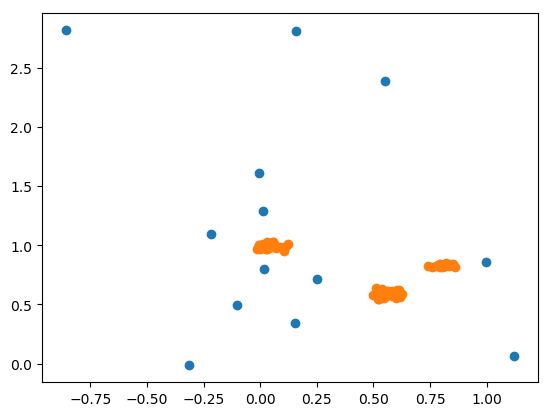

In [4]:
figure()
X = dataset.data
y = dataset.labels
scatter(X[1, y.==1], X[2, y.==1])
scatter(X[1, y.==0], X[2, y.==0])
show()

In [43]:
# set problem dimensions
indim = size(X,1)
hiddendim = 4
latentdim = 2
nlayers = 3
# hiddendim should be more then 3, then it works

# other model settings
contamination = size(y[y.==1],1)/size(y[y.==0],1) # to set the decision threshold
activation = Flux.relu
threshold = 0
iterations = 100
cbthrottle = 1
verbfit = true

#
x = X[:,y .== 0]

#
model = AEmodel(indim, hiddendim, latentdim, nlayers, activation, threshold, contamination,
    iterations, cbthrottle, verbfit)

AnomalyDetection.AEmodel(AnomalyDetection.AE{Flux.Chain,Flux.Chain}(Chain(Chain(Chain(Dense(2, 4, NNlib.relu), Dense(4, 4, NNlib.relu)), Dense(4, 4, NNlib.relu)), Dense(4, 2)), Chain(Chain(Chain(Dense(2, 4, NNlib.relu), Dense(4, 4, NNlib.relu)), Dense(4, 4, NNlib.relu)), Dense(4, 2))), 0, 0.14444444444444443, 100, 1, true)

In [44]:
# model might have to be restarted if loss is > 0.01
model.verbfit = true
for i in 1:10
    AnomalyDetection.fit!(model, x)
end

loss: 0.4980706088927668

loss: 0.1885357481398361

loss: 0.028134024564913297

loss: 0.00719556154934693

loss: 0.0009961119195374762

loss: 0.000102138767852459

loss: 0.0003467452257882398

loss: 0.00035528501485694423

loss: 0.00038903888236229344

loss: 0.0003538693869653098



In [45]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.803537  0.80492   0.807251  0.81979   …  0.0357467  0.0611161  0.0695159
 0.822065  0.834301  0.826196  0.848244     0.974015   1.00753    0.973343 

In [46]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [47]:
model(X)

Tracked 2×103 Array{Float64,2}:
 0.803537  0.80492   0.807251  0.81979   …  0.0649782  0.260949  0.0316044
 0.822065  0.834301  0.826196  0.848244     1.47727    0.714291  0.792832 

In [48]:
X

2×103 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  -0.00703644  0.252366  -0.216809
 0.821998  0.834235  0.826129  0.848182      1.6113      0.714171   1.09756 

In [49]:
# predict labels
yhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [50]:
model.verbfit = false
tryhat, tsthat = AnomalyDetection.quickvalidate!(dataset, dataset, model)


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
recall: 1.0
f1score: 0.9629629629629629
equal error rate: 0.005555555555555556

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
recall: 1.0
f1score: 0.9629629629629629
equal error rate: 0.005555555555555556


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [51]:
using ScikitLearn.Utils: meshgrid

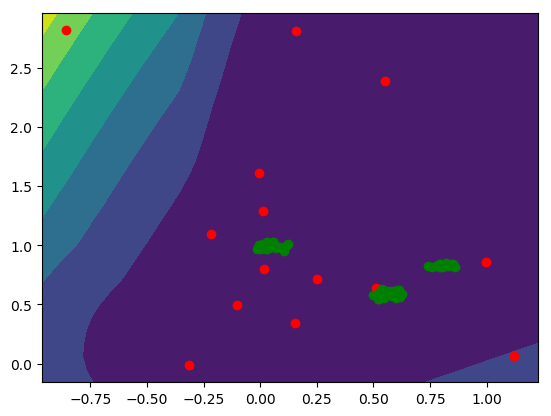

In [52]:
# plot heatmap of the fit
figure()
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.loss(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
contourf(xx, yy, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g")
show()

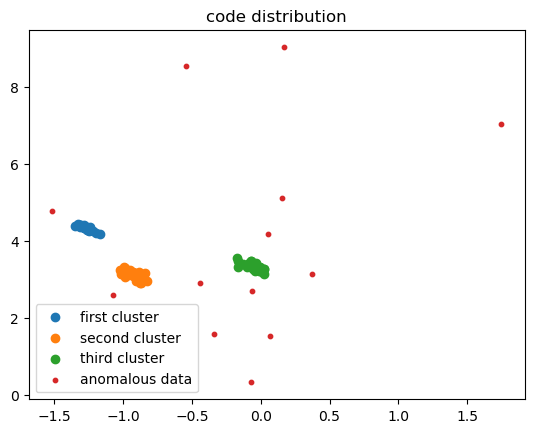

PyObject <matplotlib.legend.Legend object at 0x7f483e9a6b70>

In [54]:
# what are the codes?
z1 = model.ae.encoder(X[:,1:30]).data
z2 = model.ae.encoder(X[:,31:60]).data
z3 = model.ae.encoder(X[:,61:90]).data
za = model.ae.encoder(X[:,91:end]).data

title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()